## 工具库

In [1]:
import pandas as pd
import numpy as np
import datetime
import xgboost as xgb
from xgboost import plot_importance
import operator
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings("ignore")

In [3]:
train_auth_info = pd.read_csv('./data/AI_Risk_Train_V3.0/train_auth_info.csv', low_memory=False)           
train_bankcard_info = pd.read_csv('./data/AI_Risk_Train_V3.0/train_bankcard_info.csv', low_memory=False)
train_credit_info = pd.read_csv('./data/AI_Risk_Train_V3.0/train_credit_info.csv', low_memory=False)
train_order_info = pd.read_csv('./data/AI_Risk_Train_V3.0/train_order_info.csv', low_memory=False)
train_recieve_addr_info = pd.read_csv('./data/AI_Risk_Train_V3.0/train_recieve_addr_info.csv', low_memory=False)
train_user_info = pd.read_csv('./data/AI_Risk_Train_V3.0/train_user_info.csv', low_memory=False)
train_target = pd.read_csv('./data/AI_Risk_Train_V3.0/train_target.csv', low_memory=False)

In [4]:
def setlen(group):
    return len(set(group))

def return_set(group):
    return set(group)

In [5]:
train_auth_info.head()

,id_card,auth_time,phone,id
0,4****************0,2017-06-10,132****2008,501951980776722440
1,NaN,NaN,187*****500,525890212484616200
2,5****************9,2015-10-10,135****3522,599309364691472392
3,NaN,NaN,136*****651,582559913071350024
4,3****************0,2016-12-19,137****4241,599017959926534408


In [6]:
'''
身份证账号是否为空
认证时间是否为空
电话号码是否为空
是否所有信息都为空，除了 id
是否所有信息都不为空
认证时间和身份证是否同时为空
认证时间和手机号码是否同时为空
'''
def auth_info(data):
    data['id_card_isnull'] = [1 if type(i) == str else 0 for i in data.id_card]
    data['phone_isnull'] = [1 if type(i) == str else 0 for i in data.phone]
    data['auth_time_isnull'] = [1 if type(i) == str else 0 for i in data.auth_time]
    return data[['id_card_isnull', 'phone_isnull', 'auth_time_isnull', 'id']]

In [7]:
train_bankcard_info.head()

,bank_name,tail_num,card_type,phone,id
0,中信银行,9753,储蓄卡,177****8427,585401206734589960
1,农业银行,2174,储蓄卡,150****4551,587694980785508360
2,中国交通银行,4832,信用卡,185****1989,602098357531316232
3,北京银行,5697,储蓄卡,186****1634,567205103669350408
4,中信银行,7703,储蓄卡,158****7655,577538085852549384


In [8]:
train_bankcard_info['card_type'].value_counts()

储蓄卡    210089
信用卡    105400
Name: card_type, dtype: int64

In [9]:
'''
用户有多少条记录
用户有多少个不同的手机号码
用户的储蓄卡的数量
用户的信用卡的数量
用户是否有信用卡
用户有几种不同类型的银行卡
用户银行卡数量是否大于 6
用户是否只有一张银行卡
'''
def bankcard_info(data):
    data['card_1'] = [1 if i == '储蓄卡' else 0 for i in data['card_type']]
    data['card_2'] = [1 if i == '信用卡' else 0 for i in data['card_type']]
    card_1_cnt = pd.pivot_table(data, index='id', values='card_1', aggfunc='sum').reset_index().rename(columns={'card_1': 'card_1_cnt'})
    data = data.merge(card_1_cnt, on='id', how='left')
    card_2_cnt = pd.pivot_table(data, index='id', values='card_2', aggfunc='sum').reset_index().rename(columns={'card_2': 'card_2_cnt'})
    data = data.merge(card_2_cnt, on='id', how='left')
    bank_cnt = pd.pivot_table(data, index='bank_name', values='tail_num', aggfunc='count').reset_index().rename(columns={'tail_num': 'bank_cnt'})
    id_bank_cnt = pd.pivot_table(data, index='id', values='bank_name', aggfunc='count').reset_index().rename(columns={'bank_name': 'id_bank_cnt'})
    id_phone_set = pd.pivot_table(data, index='id', values='phone', aggfunc=setlen).reset_index().rename(columns={'phone': 'id_phone_set'})
    id_card_set = pd.pivot_table(data, index='id', values='card_type', aggfunc=setlen).reset_index().rename(columns={'card_type': 'id_card_set'})
    id_bank_set = pd.pivot_table(data, index='id', values='bank_name', aggfunc=setlen).reset_index().rename(columns={'bank_name': 'id_bank_set'})

    data = data.merge(bank_cnt, on='bank_name', how='left')
    data = data.merge(id_bank_cnt, on='id', how='left')
    data = data.merge(id_phone_set, on='id', how='left')
    data = data.merge(id_card_set, on='id', how='left')  # ?
    data = data.merge(id_bank_set, on='id', how='left')  # ?
    return data[['id', 'card_1_cnt', 'card_2_cnt', 'id_bank_cnt', 'id_phone_set', 'id_card_set', 'id_bank_set']].drop_duplicates(['id'])

In [10]:
train_credit_info.head()

,credit_score,overdraft,quota,id
0,549.0,0.0,0.0,563888070781309192
1,400.0,0.0,0.0,591567740590887176
2,490.0,4955.9,5083.0,464888846169936136
3,387.0,0.0,0.0,514996919311798280
4,394.0,0.0,0.0,20160629090004442243


In [11]:
'''
用户信用积分
用户额度是否为 0
用户已使用的额度
用户的信用额度
用户剩余的额度
用户额度使用率
用户额度排名
是否所有信息都为空，除了 id
是否所有信息都为 0，除了 id
信用额度是否为 0
信用积分是否为 0
用户是否还有剩余的额度
'''
def credit_info(data):
    data['q_o'] = data['quota'] - data['overdraft']
    data['quota'] = [1 if i is np.nan else i for i in data['quota']]
    data['overdraft'] = [1 if i is np.nan else i for i in data['overdraft']]
    data['q/o'] = data[['quota', 'overdraft']].apply(lambda x: 0 if x.quota == 0 else x.overdraft/x.quota, axis=1)
    return data.drop_duplicates(['id'])

In [12]:
train_order_info.head()

,amt_order,type_pay,time_order,sts_order,phone,unit_price,id,no_order_md5,name_rec_md5,product_id_md5
0,39.0,在线支付,2017-04-15 09:21:18,等待收货,159****2937,NaN,609460154345197832,ae3b7fd144ff7ee8658d92137a924836,afeb593025b37afbe8179c456b8855f1,NaN
1,39.0,在线支付,2017-04-15 09:21:18,完成,159****2937,NaN,609460154345197832,ae3b7fd144ff7ee8658d92137a924836,afeb593025b37afbe8179c456b8855f1,NaN
2,288.0,在线支付,2016-10-24 08:57:06,NaN,137****8223,NaN,609460154345197832,1d7b1294cdbfe24815e39c458cd059d1,eac9416f834d481d7c88da6134468d03,NaN
3,428.0,在线支付,2016-10-27 20:04:48,完成,137****8223,NaN,609460154345197832,51ee194476e14e9976db834c08f20e21,eac9416f834d481d7c88da6134468d03,NaN
4,428.0,在线支付,2016-10-27 20:04:48,NaN,137****8223,NaN,609460154345197832,51ee194476e14e9976db834c08f20e21,eac9416f834d481d7c88da6134468d03,NaN


In [13]:
'''
用户记录是否有除 id 外都为空
用户关于商品单价的统计特征
用户关于订单金额的统计特征
支付方式的离散特征
订单状态的离散特征
'''
def order_info(data):
    id_sample = data.drop_duplicates(['id'])[['id']]

    data = data.drop_duplicates()
    order_info_amt = data[['amt_order']]
    order_info_amt = order_info_amt[order_info_amt['amt_order'].notnull()]
    order_info_amt = order_info_amt[order_info_amt['amt_order'] != 'null']
    order_info_amt['amt_order'] = [float(index) for index in order_info_amt['amt_order']]
    mean = order_info_amt['amt_order'].mean()
    data['amt_order'] = data['amt_order'].fillna(mean)
    data['amt_order'] = [mean if index == 'null' else index for index in data['amt_order']]
    data['amt_order'] = [float(index) for index in data['amt_order']]

    data['pay_way_1'] = [1 if i == '在线支付' else 0 for i in data['type_pay']]
    way1_cnt = pd.pivot_table(data, index='id', values='pay_way_1', aggfunc='sum').reset_index().rename(columns={'pay_way_1': 'way1_cnt'})
    id_sample = id_sample.merge(way1_cnt, on='id', how='left')
    data['pay_way_2'] = [1 if i == '货到付款' else 0 for i in data['type_pay']]
    way2_cnt = pd.pivot_table(data, index='id', values='pay_way_2', aggfunc='sum').reset_index().rename(columns={'pay_way_2': 'way2_cnt'})
    id_sample = id_sample.merge(way2_cnt, on='id', how='left')

    '''统计计数特征'''
    f9 = pd.pivot_table(data[['id', 'type_pay']], index='id', values='type_pay', aggfunc=setlen).reset_index().rename(columns={'type_pay': 'id_type_pay_set'})
    id_sample = id_sample.merge(f9, on='id', how='left')
    f10 = pd.pivot_table(data[['id', 'sts_order']], index='id', values='sts_order', aggfunc=setlen).reset_index().rename(columns={'sts_order': 'id_sts_order_set'})
    id_sample = id_sample.merge(f10, on='id', how='left')
    f11 = pd.pivot_table(data[['id', 'phone']], index='id', values='phone', aggfunc=setlen).reset_index().rename(columns={'phone': 'id_phone_set'})
    id_sample = id_sample.merge(f11, on='id', how='left')

    '''其他特征'''
    data['sts_order'] = data['sts_order'].fillna('0')
    data['wan_cheng'] = [1 if ('完成' in i) else 0 for i in data['sts_order']]
    wan_cheng_cnt = pd.pivot_table(data, index='id', values='wan_cheng', aggfunc='sum').reset_index().rename(columns={'wan_cheng': 'wan_cheng_cnt'})
    id_sample = id_sample.merge(wan_cheng_cnt, on='id', how='left')
    data['cheng_gong'] = [1 if '成功' in i else 0 for i in data['sts_order']]
    print(data['cheng_gong'])
    cheng_gong_cnt = pd.pivot_table(data, index='id', values='cheng_gong', aggfunc='sum').reset_index().rename(columns={'cheng_gong': 'cheng_gong_cnt'})
    id_sample = id_sample.merge(cheng_gong_cnt, on='id', how='left')
    data['qu_xiao'] = [1 if '取消' in i else 0 for i in data['sts_order']]
    qu_xiao_cnt = pd.pivot_table(data, index='id', values='qu_xiao', aggfunc='sum').reset_index().rename(columns={'qu_xiao': 'qu_xiao_cnt'})
    id_sample = id_sample.merge(qu_xiao_cnt, on='id', how='left')

    return id_sample.drop_duplicates(['id'])

In [14]:
train_recieve_addr_info.head()

,addr_id,region,phone,fix_phone,id,receiver_md5
0,NaN,NaN,NaN,NaN,575150029610684424,NaN
1,137816020.0,辽宁营口市鲅鱼圈区芦屯镇,186****4600,186****4600,563888070781309192,798371eaefb014d304e8c90ba0af1d09
2,137630418.0,辽宁营口市鲅鱼圈区红海街道,159****1000,159****1000,563888070781309192,41c14ef94733b4587f11ffb64e58a72d
3,137816021.0,辽宁营口市鲅鱼圈区芦屯镇,186****4600,NaN,563888070781309192,798371eaefb014d304e8c90ba0af1d09
4,138135925.0,辽宁营口市鲅鱼圈区芦屯镇,189****9687,189****9687,563888070781309192,2d3e7dc595265a37f1e9eee82a15b047


In [15]:
'''
用户记录中是否有除 id 外都为空
'addr_id', 'region', 'phone', 'fix_phone', 'receiver_md5'是否同时为空
用户的记录数
用户收获地址中的省份离散特征
用户收获地址中有多少不同的省份
'''
def recieve_addr_info(data):
    province = {'甘肃', '云南', '贵州', '河南', '黑龙', '香港', '北京', '湖南', '江苏', '青海', '宁夏', '内蒙', '浙江', '吉林', '海南', '福建', '重庆', '台湾', '陕西', '湖北', '江西', '辽宁', '山西', '西藏', '广东', '安徽', '四川', '河北', '山东', '上海',
                '广西', '新疆', '天津', 'null'}
    data['province'] = data[['region']].apply(lambda x: 'null' if x.region is np.nan else x.region[0:2], axis=1)
    city_set = pd.pivot_table(data, index='id', values='province', aggfunc=return_set).reset_index()
    for string in list(province):
        city_set[string] = [1 if string in index else 0 for index in city_set['province']]
    city_set['province_p'] = city_set[['province']].apply(lambda x: x.province.clear() if 'null' in x.province else x.province, axis=1)
    city_set['province_len'] = [0 if index is None else len(index) for index in city_set['province']]

    data['phone_isnull'] = [0 if type(i) == float else 1 for i in data.phone]
    data['fix_phone_isnull'] = [1 if type(i) == str else 0 for i in data.fix_phone]
    id_phone_set = pd.pivot_table(data[['id', 'phone']], index='id', values='phone', aggfunc=setlen).reset_index().rename(columns={'phone': 'id_phone_set'})
    data = data.merge(id_phone_set, on='id', how='left')
    data = data.merge(city_set, on='id', how='left')

    return data[['id', 'phone_isnull', 'fix_phone_isnull', 'id_phone_set', 'province_len']].drop_duplicates(['id'])

In [16]:
train_user_info.head()

,sex,birthday,hobby,merriage,income,id_card,degree,industry,qq_bound,wechat_bound,account_grade,id
0,保密,NaN,NaN,NaN,NaN,NaN,NaN,NaN,未绑定,已绑定,铜牌会员,588238879438409736
1,保密,NaN,NaN,NaN,NaN,NaN,NaN,NaN,已绑定,未绑定,铜牌会员,601460242772922632
2,保密,NaN,NaN,NaN,NaN,NaN,NaN,NaN,未绑定,已绑定,金牌会员,601137941405765640
3,保密,0000-00-00,NaN,NaN,NaN,NaN,NaN,NaN,已绑定,未绑定,注册会员,20160429090002533592
4,男,1994-10-04,NaN,NaN,NaN,NaN,NaN,NaN,已绑定,未绑定,注册会员,613466575764197640


In [17]:
'''
用户生日是否是“0000-00-00”
用户性别的 one-hot 编码
用户婚姻状况的 one-hot 编码
用户会员等级的 one-hot 编码
用户是否绑定 QQ
用户是否绑定微信号
用户学历是否是“硕士、其它、博士”
用户身份证号是否为空
用户会员收入的 one-hot 编码
'''
def user_info(data):
    id_sample = data[['id']]
    degree = ['本科', '初中', '中专', '其他', '硕士', '大专', '博士', '高中']
    for index in degree:
        id_sample[index] = [1 if index == string else 0 for string in data['degree']]

    id_sample['sex_isnull'] = [0 if type(index) == float else 1 for index in data['sex']]
    id_sample['sex1'] = [1 if index == '保密' else 0 for index in data['sex']]
    id_sample['sex2'] = [1 if index == '男' else 0 for index in data['sex']]
    id_sample['sex3'] = [1 if index == '女' else 0 for index in data['sex']]

    id_sample['0000-00-00'] = [1 if index == '0000-00-00' else 0 for index in data['birthday']]

    id_sample['merriage1'] = [1 if index == '未婚' else 0 for index in data['merriage']]
    id_sample['merriage2'] = [1 if index == '已婚' else 0 for index in data['merriage']]
    id_sample['merriage3'] = [1 if index == '保密' else 0 for index in data['merriage']]

    id_sample['income_isnull'] = [1 if type(index) == str else 0 for index in data['income']]
    id_sample['income1'] = [1 if index == '4000-5999元' else 0 for index in data['income']]
    id_sample['income2'] = [1 if index == '8000元以上' else 0 for index in data['income']]
    id_sample['income3'] = [1 if index == '2000-3999元' else 0 for index in data['income']]
    id_sample['income4'] = [1 if index == '6000-7999元' else 0 for index in data['income']]
    id_sample['income5'] = [1 if index == '2000元以下' else 0 for index in data['income']]

    id_sample['id_card_isnull'] = [1 if type(index) == str else 0 for index in data['id_card']]

    id_sample['qq_bound_one'] = [1 if index == '已绑定' else 0 for index in data['qq_bound']]
    id_sample['qq_bound_two'] = [1 if index == '未绑定' else 0 for index in data['qq_bound']]

    id_sample['wechat_bound_one'] = [1 if index == '已绑定' else 0 for index in data['wechat_bound']]
    id_sample['wechat_bound_two'] = [1 if index == '未绑定' else 0 for index in data['wechat_bound']]

    id_sample['account_grade_one'] = [1 if index == '注册会员' else 0 for index in data['account_grade']]
    id_sample['account_grade_two'] = [1 if index == '铜牌会员' else 0 for index in data['account_grade']]
    id_sample['account_grade_three'] = [1 if index == '银牌会员' else 0 for index in data['account_grade']]
    id_sample['account_grade_four'] = [1 if index == '金牌会员' else 0 for index in data['account_grade']]
    id_sample['account_grade_five'] = [1 if index == '钻石会员' else 0 for index in data['account_grade']]
    return id_sample.drop_duplicates(['id'])

In [18]:
train_target.head()

,appl_sbm_tm,target,id
0,2017-04-08 19:10:13.0,0,600689284231467016
1,2016-06-08 15:20:21.0,0,20160608150003808365
2,2016-04-27 11:36:27.0,0,20160427110002485018
3,2017-03-30 08:45:55.0,0,593852820159991816
4,2016-11-30 11:40:38.0,0,506970882778861832


In [19]:
'''
用户年龄
用户注册天数
用户借贷日期是否早于注册日期
下订单时间与注册时间的天数差的最大、最小、平均
'''
def days_feature(auth, order, appl):
    data = auth.merge(appl, on='id', how='left')
    data['auth_time'] = data[['appl_sbm_tm', 'auth_time']].apply(lambda x: x.appl_sbm_tm[:10] if x.auth_time == '0000-00-00' else x.auth_time, axis=1)
    data['auth_time'] = data[['appl_sbm_tm', 'auth_time']].apply(lambda x: x.appl_sbm_tm[:10] if x.auth_time is np.nan else x.auth_time, axis=1)
    data['days'] = data[['auth_time', 'appl_sbm_tm']].apply(lambda x: (datetime.datetime.strptime(x.appl_sbm_tm[:10], '%Y-%m-%d') - datetime.datetime.strptime(x.auth_time[:10], '%Y-%m-%d')).days, axis=1)
    data['days_is_neg'] = [1 if i > 0 else 0 for i in data['days']]
    data['auth_year'] = data[['auth_time']].apply(lambda x: int(x.auth_time[:4]), axis=1)
    data['appl_year'] = data[['appl_sbm_tm']].apply(lambda x: int(x.appl_sbm_tm[:4]), axis=1)
    data['years'] = data['appl_year'] - data['auth_year']
    data['years_is_neg'] =data[['years']].apply(lambda x: 1 if x.years > 0 else 0, axis=1)
    print("OK")
    return data[['id', 'days', 'days_is_neg', 'years', 'years_is_neg']].drop_duplicates(['id'])

In [20]:
def auth_order(auth, order):
    data = auth.merge(order, on='id', how='left')
    data['auth_time'] = [i if type(i) == str else '0001-01-01' for i in data['auth_time']]
    data['auth_time'] = ['0001-01-01' if i == '0000-00-00' else i for i in data['auth_time']]
    data['auth_time'] = ['0001-01-01' if i == 0 else i for i in data['auth_time']]
    data['time_order'] = [i if type(i) == str else '0001-01-01 00:00:00' for i in data['time_order']]
    data['time_order'] = [i if len(i) > 16 else '0001-01-01 00:00:00' for i in data['time_order']]

    data['time_days'] = data[['auth_time', 'time_order']].apply(
        lambda x: abs((datetime.datetime.strptime(x.time_order, '%Y-%m-%d %H:%M:%S') - datetime.datetime.strptime(x.auth_time, '%Y-%m-%d')).days), axis=1)
    data['time_days'] = [i if ((i < 50000) & (i > 0)) else -1 for i in data['time_days']]
    time_days_mean = pd.pivot_table(data[['id', 'time_days']], index='id', values='time_days', aggfunc='mean').reset_index().rename(columns={'time_days': 'time_days_mean'})
    auth = auth.merge(time_days_mean, on='id', how='left')
    auth['time_days_mean_is_neg'] = [1 if i > 0 else 0 for i in auth['time_days_mean']]
    return auth[['id', 'time_days_mean', 'time_days_mean_is_neg']]

In [21]:
def validation():
    '''训练集读取、提特征'''
    train_auth_info = pd.read_csv('./data/AI_Risk_Train_V3.0/train_auth_info.csv', low_memory=False)
    f_train_auth_info = auth_info(train_auth_info)
    train_bankcard_info = pd.read_csv('./data/AI_Risk_Train_V3.0/train_bankcard_info.csv', low_memory=False)
    f_train_bankcard_info = bankcard_info(train_bankcard_info)
    train_credit_info = pd.read_csv('./data/AI_Risk_Train_V3.0/train_credit_info.csv', low_memory=False)
    f_train_credit_info = credit_info(train_credit_info)
    train_order_info = pd.read_csv('./data/AI_Risk_Train_V3.0/train_order_info.csv', low_memory=False)
    f_train_order_info = order_info(train_order_info)
    train_recieve_addr_info = pd.read_csv('./data/AI_Risk_Train_V3.0/train_recieve_addr_info.csv', low_memory=False)
    f_train_recieve_addr_info = recieve_addr_info(train_recieve_addr_info)
    train_user_info = pd.read_csv('./data/AI_Risk_Train_V3.0/train_user_info.csv', low_memory=False)
    f_train_user_info = user_info(train_user_info)
    train_target = pd.read_csv('./data/AI_Risk_Train_V3.0/train_target.csv', low_memory=False)
    feature_l = train_target[['id', 'target']]
    day_minus = days_feature(train_auth_info[['id', 'auth_time']], train_order_info[['id', 'time_order']], train_target[['id', 'appl_sbm_tm']])
    auth_or = auth_order(train_auth_info[['id', 'auth_time']], train_order_info[['id', 'time_order']])

    '''划分验证集'''
    feature_l['date'] = [index.replace('-', '') for index in train_target['appl_sbm_tm']]
    feature_l['date'] = [index.split(' ')[0][0:6] for index in feature_l['date']]
    validation_train = feature_l[feature_l['date'] != '201704'][['target', 'id']]
    validation_test = feature_l[feature_l['date'] == '201704'][['target', 'id']]

    '''validation_train'''
    validation_train = validation_train.merge(f_train_auth_info, on='id', how='left')
    validation_train = validation_train.merge(f_train_bankcard_info, on='id', how='left')
    validation_train = validation_train.merge(f_train_credit_info, on='id', how='left')
    validation_train = validation_train.merge(f_train_order_info, on='id', how='left')
    validation_train = validation_train.merge(f_train_recieve_addr_info, on='id', how='left')
    validation_train = validation_train.merge(f_train_user_info, on='id', how='left')
    validation_train = validation_train.merge(day_minus, on='id', how='left')
    validation_train = validation_train.merge(auth_or, on='id', how='left')

    validation_train_f = validation_train.drop(['target', 'id'], axis=1)
    validation_train_l = validation_train[['target']]
    print(validation_train_f.columns)

    '''validation_test'''
    validation_test = validation_test.merge(f_train_auth_info, on='id', how='left')
    validation_test = validation_test.merge(f_train_bankcard_info, on='id', how='left')
    validation_test = validation_test.merge(f_train_credit_info, on='id', how='left')
    validation_test = validation_test.merge(f_train_order_info, on='id', how='left')
    validation_test = validation_test.merge(f_train_recieve_addr_info, on='id', how='left')
    validation_test = validation_test.merge(f_train_user_info, on='id', how='left')
    validation_test = validation_test.merge(day_minus, on='id', how='left')
    validation_test = validation_test.merge(auth_or, on='id', how='left')
    print(validation_test.shape)

    validation_test_f = validation_test.drop(['target', 'id'], axis=1)
    validation_test_l = validation_test[['target']]

    xgb_train = xgb.DMatrix(validation_train_f, label=validation_train_l)
    xgb_test = xgb.DMatrix(validation_test_f, label=validation_test_l)
    watchlist = [(xgb_train, 'train'), (xgb_test, 'val')]
    params = {
        'booster': 'gbtree',
        'objective': 'binary:logistic',
        'gamma': 0.1,  # 用于控制是否后剪枝的参数,越大越保守，一般0.1、0.2这样子。
        'max_depth': 5,  # 构建树的深度，越大越容易过拟合
        'lambda': 2,  # 控制模型复杂度的权重值的L2正则化项参数，参数越大，模型越不容易过拟合。
        'subsample': 0.8,  # 随机采样训练样本
        'colsample_bytree': 0.8,  # 生成树时进行的列采样
        'min_child_weight': 18,
        'silent': 0,  # 设置成1则没有运行信息输出，最好是设置为0.
        'eta': 0.03,  # 如同学习率
        'eval_metric': 'auc',
    }
    module = xgb.train(params, xgb_train, num_boost_round=500, evals=watchlist)
    result = module.predict(xgb_test)

    features = module.get_fscore()
    features = list(dict(sorted(features.items(), key=lambda d: d[1])).keys())[-20:]
    features.reverse()
    print(features)

    plot_importance(module)
    plt.show()
    print("auc: ", roc_auc_score(validation_test_l.values, result))

0          0
1          0
2          0
3          0
4          0
5          0
6          0
7          0
8          0
9          0
11         0
12         0
13         0
14         1
15         0
16         0
17         0
18         0
19         0
20         0
21         0
22         0
23         0
24         0
25         0
27         0
28         0
29         0
30         0
31         0
          ..
2415615    0
2415616    0
2415617    0
2415618    0
2415619    0
2415620    0
2415621    0
2415622    0
2415623    0
2415624    0
2415625    0
2415626    0
2415627    0
2415628    0
2415629    0
2415630    0
2415631    0
2415632    0
2415633    0
2415634    0
2415635    0
2415636    0
2415637    0
2415638    0
2415639    0
2415640    0
2415641    0
2415642    0
2415643    0
2415644    0
Name: cheng_gong, Length: 2343902, dtype: int64
OK
Index(['id_card_isnull_x', 'phone_isnull_x', 'auth_time_isnull', 'card_1_cnt',
       'card_2_cnt', 'id_bank_cnt', 'id_phone_set_x', 'id_card_set',
       '

[154]	train-auc:0.847516	val-auc:0.794319
[155]	train-auc:0.847845	val-auc:0.794479
[156]	train-auc:0.847937	val-auc:0.794615
[157]	train-auc:0.848079	val-auc:0.794363
[158]	train-auc:0.84814	val-auc:0.794485
[159]	train-auc:0.848356	val-auc:0.794717
[160]	train-auc:0.848373	val-auc:0.794867
[161]	train-auc:0.848514	val-auc:0.795122
[162]	train-auc:0.848629	val-auc:0.794898
[163]	train-auc:0.848899	val-auc:0.794915
[164]	train-auc:0.849166	val-auc:0.794828
[165]	train-auc:0.849393	val-auc:0.794851
[166]	train-auc:0.849706	val-auc:0.795016
[167]	train-auc:0.849809	val-auc:0.795237
[168]	train-auc:0.849986	val-auc:0.795265
[169]	train-auc:0.850077	val-auc:0.795041
[170]	train-auc:0.850146	val-auc:0.79509
[171]	train-auc:0.850279	val-auc:0.795189
[172]	train-auc:0.850474	val-auc:0.795273
[173]	train-auc:0.850563	val-auc:0.795166
[174]	train-auc:0.850672	val-auc:0.795203
[175]	train-auc:0.850752	val-auc:0.795153
[176]	train-auc:0.850958	val-auc:0.795217
[177]	train-auc:0.851203	val-auc:0.7

[351]	train-auc:0.866965	val-auc:0.80396
[352]	train-auc:0.86703	val-auc:0.803925
[353]	train-auc:0.867098	val-auc:0.803967
[354]	train-auc:0.867145	val-auc:0.804149
[355]	train-auc:0.867234	val-auc:0.804206
[356]	train-auc:0.867319	val-auc:0.804168
[357]	train-auc:0.867348	val-auc:0.804175
[358]	train-auc:0.867403	val-auc:0.804229
[359]	train-auc:0.867503	val-auc:0.804335
[360]	train-auc:0.867551	val-auc:0.804341
[361]	train-auc:0.867643	val-auc:0.804305
[362]	train-auc:0.867668	val-auc:0.804176
[363]	train-auc:0.867732	val-auc:0.804127
[364]	train-auc:0.86774	val-auc:0.804179
[365]	train-auc:0.867774	val-auc:0.80425
[366]	train-auc:0.867821	val-auc:0.804254
[367]	train-auc:0.867851	val-auc:0.804334
[368]	train-auc:0.867908	val-auc:0.804321
[369]	train-auc:0.867934	val-auc:0.804397
[370]	train-auc:0.868013	val-auc:0.804291
[371]	train-auc:0.868036	val-auc:0.804333
[372]	train-auc:0.868155	val-auc:0.80438
[373]	train-auc:0.868175	val-auc:0.804461
[374]	train-auc:0.868254	val-auc:0.8044

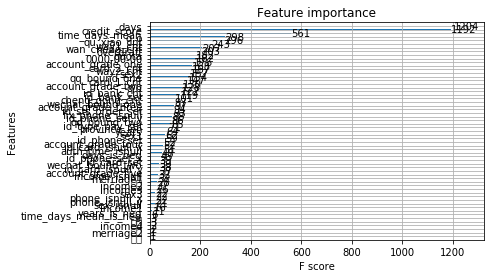

auc:  0.8061947133942906


In [22]:
validation()

In [23]:
def submit():
    '''训练集读取、提特征'''
    train_auth_info = pd.read_csv('./data/AI_Risk_Train_V3.0/train_auth_info.csv', low_memory=False)           
    f_train_auth_info = auth_info(train_auth_info)
    train_bankcard_info = pd.read_csv('./data/AI_Risk_Train_V3.0/train_bankcard_info.csv', low_memory=False)
    f_train_bankcard_info = bankcard_info(train_bankcard_info)
    train_credit_info = pd.read_csv('./data/AI_Risk_Train_V3.0/train_credit_info.csv', low_memory=False)
    f_train_credit_info = credit_info(train_credit_info)
    train_order_info = pd.read_csv('./data/AI_Risk_Train_V3.0/train_order_info.csv', low_memory=False)
    f_train_order_info = order_info(train_order_info)
    train_recieve_addr_info = pd.read_csv('./data/AI_Risk_Train_V3.0/train_recieve_addr_info.csv', low_memory=False)
    f_train_recieve_addr_info = recieve_addr_info(train_recieve_addr_info)
    train_user_info = pd.read_csv('./data/AI_Risk_Train_V3.0/train_user_info.csv', low_memory=False)
    f_train_user_info = user_info(train_user_info)
    train_target = pd.read_csv('./data/AI_Risk_Train_V3.0/train_target.csv', low_memory=False)
    feature_l = train_target[['id', 'target']]
    f_day_minus = days_feature(train_auth_info[['id', 'auth_time']], train_order_info[['id', 'time_order']], train_target[['id', 'appl_sbm_tm']])
    f_auth_or = auth_order(train_auth_info, train_order_info)
    # print(f_day_minus)

    '''f_merge'''
    feature_l = feature_l.merge(f_train_auth_info, on='id', how='left')
    feature_l = feature_l.merge(f_train_bankcard_info, on='id', how='left')
    feature_l = feature_l.merge(f_train_credit_info, on='id', how='left')
    feature_l = feature_l.merge(f_train_order_info, on='id', how='left')
    feature_l = feature_l.merge(f_train_recieve_addr_info, on='id', how='left')
    feature_l = feature_l.merge(f_train_user_info, on='id', how='left')
    feature_l = feature_l.merge(f_day_minus, on='id', how='left')
    feature_l = feature_l.merge(f_auth_or, on='id', how='left')
    # feature_l.to_csv(r'./data/train_data/train_feature.csv', index=False)
    print(feature_l.shape)
    print(feature_l)
    train_f = feature_l.drop('target', axis=1)
    train_l = feature_l[['target']]

    xgb_train = xgb.DMatrix(train_f.values, label=train_l.values)
    params = {
        'booster': 'gbtree',
        'objective': 'binary:logistic',
        'gamma': 0.1,  # 用于控制是否后剪枝的参数,越大越保守，一般0.1、0.2这样子。
        'max_depth': 5,  # 构建树的深度，越大越容易过拟合
        'lambda': 2,  # 控制模型复杂度的权重值的L2正则化项参数，参数越大，模型越不容易过拟合。
        'subsample': 0.8,  # 随机采样训练样本
        'colsample_bytree': 0.8,  # 生成树时进行的列采样
        'min_child_weight': 18,
        'silent': 0,  # 设置成1则没有运行信息输出，最好是设置为0.
        'eta': 0.03,  # 如同学习率
        'eval_metric': 'logloss'
    }
    module = xgb.train(params, xgb_train, num_boost_round=500)


    '''测试集读取、提特征'''
    test_auth_info = pd.read_csv('./data/AI_Risk_data_Btest_V2.0/Btest_auth_info.csv', low_memory=False)
    f_test_auth_info = auth_info(test_auth_info)
    test_bankcard_info = pd.read_csv('./data/AI_Risk_data_Btest_V2.0/Btest_bankcard_info.csv', low_memory=False)
    f_test_bankcard_info = bankcard_info(test_bankcard_info)
    test_credit_info = pd.read_csv('./data/AI_Risk_data_Btest_V2.0/Btest_credit_info.csv', low_memory=False)
    f_test_credit_info = credit_info(test_credit_info)
    test_order_info = pd.read_csv('./data/AI_Risk_data_Btest_V2.0/Btest_order_info.csv', low_memory=False)
    f_test_order_info = order_info(test_order_info)
    test_recieve_addr_info = pd.read_csv('./data/AI_Risk_data_Btest_V2.0/Btest_recieve_addr_info.csv', low_memory=False)
    f_test_recieve_addr_info = recieve_addr_info(test_recieve_addr_info)
    test_user_info = pd.read_csv('./data/AI_Risk_data_Btest_V2.0/Btest_user_info.csv', low_memory=False)
    f_test_user_info = user_info(test_user_info)
    test_target = pd.read_csv('./data/AI_Risk_data_Btest_V2.0/Btest_list.csv', low_memory=False)
    test_fl = test_target[['id']]
    t_day_minus = days_feature(test_auth_info[['id', 'auth_time']], test_order_info[['id', 'time_order']], test_target[['id', 'appl_sbm_tm']])
    t_auth_or = auth_order(test_auth_info, test_order_info)

    '''merge'''
    test_fl = test_fl.merge(f_test_auth_info, on='id', how='left')
    test_fl = test_fl.merge(f_test_bankcard_info, on='id', how='left')
    test_fl = test_fl.merge(f_test_credit_info, on='id', how='left')
    test_fl = test_fl.merge(f_test_order_info, on='id', how='left')
    test_fl = test_fl.merge(f_test_recieve_addr_info, on='id', how='left')
    test_fl = test_fl.merge(f_test_user_info, on='id', how='left')
    test_fl = test_fl.merge(t_day_minus, on='id', how='left')
    test_fl = test_fl.merge(t_auth_or, on='id', how='left')


    test_f = test_fl
    test_l = test_fl[['id']]

    xgb_test = xgb.DMatrix(test_f.values)
    result = module.predict(xgb_test)
    test_l['predicted_score'] = result
    test_l.columns = ['ID', 'PROB']
    test_l.to_csv(r'result_xgb.csv', index=None)

In [24]:
submit()

0          0
1          0
2          0
3          0
4          0
5          0
6          0
7          0
8          0
9          0
11         0
12         0
13         0
14         1
15         0
16         0
17         0
18         0
19         0
20         0
21         0
22         0
23         0
24         0
25         0
27         0
28         0
29         0
30         0
31         0
          ..
2415615    0
2415616    0
2415617    0
2415618    0
2415619    0
2415620    0
2415621    0
2415622    0
2415623    0
2415624    0
2415625    0
2415626    0
2415627    0
2415628    0
2415629    0
2415630    0
2415631    0
2415632    0
2415633    0
2415634    0
2415635    0
2415636    0
2415637    0
2415638    0
2415639    0
2415640    0
2415641    0
2415642    0
2415643    0
2415644    0
Name: cheng_gong, Length: 2343902, dtype: int64
OK
(120929, 66)
                          id  target  id_card_isnull_x  phone_isnull_x  \
0         600689284231467016       0                 1               

FileNotFoundError: [Errno 2] File b'./data/AI_Risk_data_Btest_V2.0/Btest_auth_info.csv' does not exist: b'./data/AI_Risk_data_Btest_V2.0/Btest_auth_info.csv'